# GAN
---
By richie

In [1]:
import numpy as np
import pandas as pd
from keras import Model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.src.models import Sequential
from keras.src.layers import Dense, LSTM, Dropout, LeakyReLU, Reshape
from keras.src.optimizers import Adam
from keras.src.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Load and preprocess the data
file_path = 'data.csv'
df = pd.read_csv(file_path)

In [3]:
# Convert the 'Statistical Period' to datetime and set it as the index
df['Statistical Period'] = pd.to_datetime(df['Statistical Period'])
df.set_index('Statistical Period', inplace=True)

In [4]:
# Select the 'PV Yield (kWh)' column and forward fill missing values
solar_power_data = df['PV Yield (kWh)'].fillna(method='ffill').values

/var/folders/pd/qsy0fv9j0ts43m9j8cbg5r5r0000gn/T/ipykernel_53047/941049339.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  solar_power_data = df['PV Yield (kWh)'].fillna(method='ffill').values


In [5]:
# Normalize the data to the range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
solar_power_data_scaled = scaler.fit_transform(solar_power_data.reshape(-1, 1))

In [6]:
# Set sequence length (window size) for the time series
seq_length = 24  # We will use 24 hours (1 day) sequences

In [7]:
# Function to create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# Create input sequences
X = create_sequences(solar_power_data_scaled, seq_length)

In [8]:
# Reshape X to have the shape: (samples, seq_length, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [9]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]

#### Define The GAN Architecture

In [10]:
# Build the Generator Model
def build_generator(seq_length):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(seq_length, activation='tanh'))
    model.add(Reshape((seq_length, 1)))  # Reshape output to match the expected shape of discriminator
    return model
    

In [11]:
# Build the Discriminator Model
def build_discriminator(seq_length):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Single output for binary classification (real/fake)
    return model


In [12]:
# Build and compile the discriminator
discriminator = build_discriminator(seq_length)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

/Users/richie/.venv/dev/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/richie/.venv/dev/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
# Build the generator
generator = build_generator(seq_length)

In [14]:
# GAN model combining generator and discriminator
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during generator training
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [15]:
# Manually ensure `loss_tracker` is initialized properly
def initialize_loss_tracker(model: Model):
    if not hasattr(model, '_loss_tracker') or model._loss_tracker is None:
        model._loss_tracker = tf.keras.metrics.Mean(name="loss")
        print("Initialized loss tracker for model.")
        
# Check if loss tracker exists for both models
initialize_loss_tracker(discriminator)
initialize_loss_tracker(gan)

Initialized loss tracker for model.


In [16]:
# Train the GAN
def train_gan(gan, generator, discriminator, X_train, epochs=10000, batch_size=32):
    real = np.ones((batch_size, 1))  # Labels for real data
    fake = np.zeros((batch_size, 1))  # Labels for fake data

    for epoch in range(epochs):
        # Train discriminator with real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        
        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, seq_length, 1))  # Corrected shape for LSTM
        fake_data = generator.predict(noise)

        # Train the discriminator (real classified as real and fake as fake)
        d_loss_real = discriminator.train_on_batch(real_data, real)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (wants discriminator to classify fake data as real)
        noise = np.random.normal(0, 1, (batch_size, seq_length, 1))  # Corrected shape for LSTM
        g_loss = gan.train_on_batch(noise, real)

        # Print progress every 1000 epochs
        if epoch % 1000 == 0:
            print(f'{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]')

# Train the GAN
train_gan(gan, generator, discriminator, X_train, epochs=100, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


/Users/richie/.venv/dev/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6949988603591919] [G loss: 0.6931666135787964]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [17]:
# Generate future forecasts using the generator and test on the test data
def generate_forecast(generator, steps=24):
    noise = np.random.normal(0, 1, (1, steps, 1))  # Corrected noise shape
    generated_data = generator.predict(noise)
    
    # Reshape from 3D to 2D for inverse_transform
    generated_data_reshaped = generated_data.reshape(-1, 1)
    
    return scaler.inverse_transform(generated_data_reshaped)

# Generate forecast for the test set (use the generator to forecast sequences)
test_forecasts = []
for i in range(len(X_test)):
    forecast = generate_forecast(generator, steps=seq_length)
    
    # Append the flattened forecast
    test_forecasts.append(forecast.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━

In [18]:
# Convert the forecast list into an array
test_forecasts = np.array(test_forecasts)

In [19]:
# Inverse scaling of the real test data
X_test_rescaled = scaler.inverse_transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

In [20]:
# Calculate RMSE between actual test data and forecasted data
rmse = np.sqrt(mean_squared_error(X_test_rescaled.flatten(), test_forecasts.flatten()))
print(f'RMSE on test data: {rmse}')

RMSE on test data: 1.8819664913084035


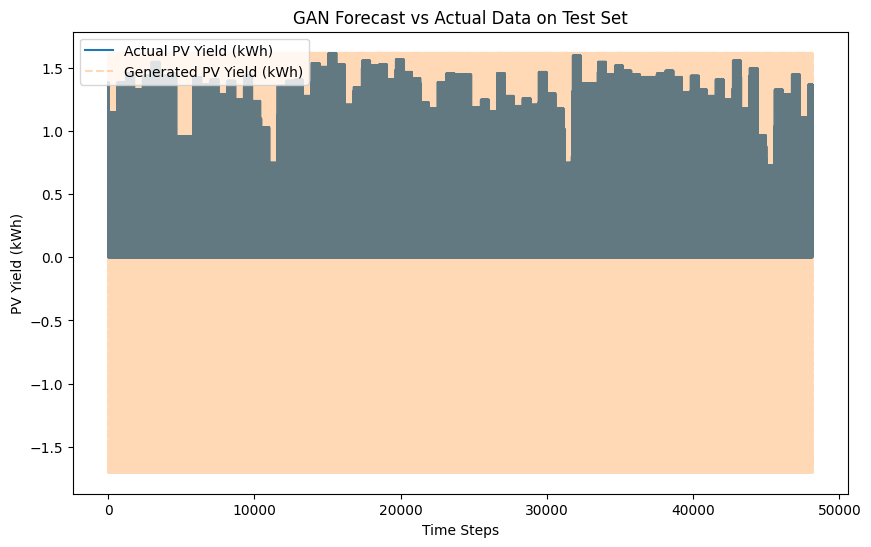

In [22]:
# Plot actual vs generated data for the test set
plt.figure(figsize=(10, 6))
plt.plot(X_test_rescaled.flatten(), label='Actual PV Yield (kWh)')
plt.plot(test_forecasts.flatten(), label='Generated PV Yield (kWh)', linestyle='dashed', alpha=0.3)
plt.title('GAN Forecast vs Actual Data on Test Set')
plt.xlabel('Time Steps')
plt.ylabel('PV Yield (kWh)')
plt.legend()
plt.show()